# Learning to regress polynomial time series<br/>using a fully convolutional network
#### This is a Python3 notebook

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
Sequential = keras.models.Sequential
Conv1D = keras.layers.Conv1D
Adam = keras.optimizers.Adam
DEFAULT_ADAM_LR = 0.001

In [2]:
window_size = 10
hidden_size = 20
seq_length = 100
n_train = 1000
n_test = 1000
lr_multiplier = 10

In [3]:
def create_model(window_size, hidden_size, seq_length=None, display_summary=True,
                 learning_rate=DEFAULT_ADAM_LR):
    """
    seq_length=None: flexible sequence length. recommended for actual usage.
    seq_length=NUMBER: recommended for model summary.
    """
    model = Sequential()
    model.add(Conv1D(name='window_conv', filters=hidden_size, kernel_size=window_size,
                     input_shape=(seq_length, 1), padding='valid', activation='relu'))
    model.add(Conv1D(name='hidden1', filters=hidden_size, kernel_size=1,
                     input_shape=(seq_length, hidden_size), activation='relu'))
    model.add(Conv1D(name='hidden2', filters=hidden_size, kernel_size=1,
                     input_shape=(seq_length, hidden_size), activation='relu'))
    model.add(Conv1D(name='regressor', filters=1, kernel_size=1,
                     input_shape=(seq_length, hidden_size)))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate))
    if display_summary:
        model.summary()
    return model

In [4]:
def generate_polynomial_sequences(seq_length, num_seqs, degree=3, span=2):
    seq = np.zeros((num_seqs, seq_length))
    x = np.linspace(-span, span, seq_length)
    monoms = x[:, np.newaxis] ** range(degree + 1)
    coeffs = np.random.randn(num_seqs, degree + 1)
    polynomes = np.matmul(coeffs, monoms.T)
    return polynomes

In [5]:
def plot_preds(real, predicted, num_plot=5, title=None):
    plt.figure()
    window_size = real.shape[1] - predicted.shape[1]
    plt.axvline(window_size, linestyle=':', color='k')
    x_real = np.arange(real.shape[1])
    x_pred = np.arange(window_size, real.shape[1])
    if title is not None:
        plt.title(title)
    for i_poly in np.random.randint(real.shape[0], size=num_plot):
        color = np.random.rand(3) * 0.75
        plt.plot(x_real, real[i_poly,:], color=color, linewidth=5)
        plt.plot(x_pred, predicted[i_poly,:], '--', color='k')
    plt.show()

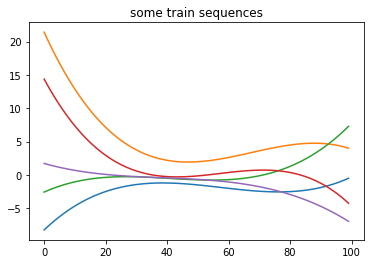

In [6]:
sequences_train = generate_polynomial_sequences(seq_length, n_train)
sequences_test = generate_polynomial_sequences(seq_length, n_test)

x_train = sequences_train[:, :-1, np.newaxis]
y_train = sequences_train[:, window_size:, np.newaxis]
x_test = sequences_test[:, :-1, np.newaxis]
y_test = sequences_test[:, window_size:, np.newaxis]

num_plot = 5
plot_inds = np.random.randint(sequences_train.shape[0], size=num_plot)
plt.figure()
plt.title('some train sequences')
plt.plot(sequences_train[plot_inds,:].T)
plt.show()

In [7]:
create_model(window_size, hidden_size, seq_length=seq_length - 1)
model = create_model(window_size, hidden_size, display_summary=False,
                     learning_rate=DEFAULT_ADAM_LR * lr_multiplier)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
window_conv (Conv1D)         (None, 90, 20)            220       
_________________________________________________________________
hidden1 (Conv1D)             (None, 90, 20)            420       
_________________________________________________________________
hidden2 (Conv1D)             (None, 90, 20)            420       
_________________________________________________________________
regressor (Conv1D)           (None, 90, 1)             21        
Total params: 1,081
Trainable params: 1,081
Non-trainable params: 0
_________________________________________________________________


Epoch 1/1
1000/1000 [==============================] - 1s 648us/step - loss: 1.6922


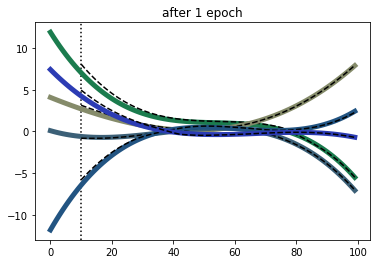

Epoch 1/2
1000/1000 [==============================] - 0s 237us/step - loss: 0.0247
Epoch 2/2
1000/1000 [==============================] - 0s 244us/step - loss: 0.0055


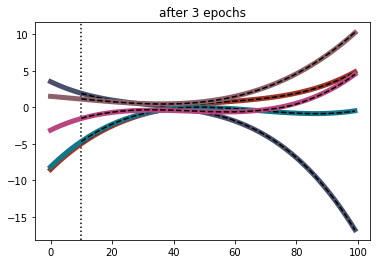

Epoch 1/6
1000/1000 [==============================] - 0s 261us/step - loss: 0.0039
Epoch 2/6
1000/1000 [==============================] - 0s 240us/step - loss: 0.0036
Epoch 3/6
1000/1000 [==============================] - 0s 260us/step - loss: 0.0033
Epoch 4/6
1000/1000 [==============================] - 0s 284us/step - loss: 0.0032
Epoch 5/6
1000/1000 [==============================] - 0s 252us/step - loss: 0.0032
Epoch 6/6
1000/1000 [==============================] - 0s 247us/step - loss: 0.0034


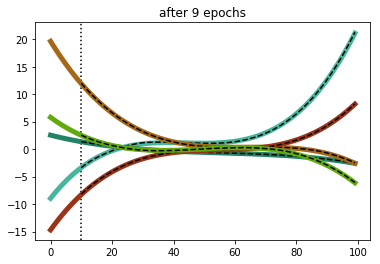


evaluating:

1000/1000 [==============================] - 0s 100us/step
loss_train: 0.003492161702364683
loss_test: 0.0032822483889758587


In [8]:
model.fit(x_train, y_train, epochs=1)
pred_test = np.squeeze(model.predict(x_test))
plot_preds(sequences_test, pred_test, title='after 1 epoch')

model.fit(x_train, y_train, epochs=2)
pred_test = np.squeeze(model.predict(x_test))
plot_preds(sequences_test, pred_test, title='after 3 epochs')

model.fit(x_train, y_train, epochs=6)
pred_test = np.squeeze(model.predict(x_test))
plot_preds(sequences_test, pred_test, title='after 9 epochs')

print('\nevaluating:\n')
loss_train = model.evaluate(x_train, y_train)
loss_test = model.evaluate(x_test, y_test)
print('loss_train:', loss_train)
print('loss_test:', loss_test)

In [9]:
%timeit np.squeeze(model.predict(x_test))
%timeit np.squeeze(model.predict(x_test))
%timeit np.squeeze(model.predict(x_test))

62.7 ms ± 3.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.4 ms ± 449 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
59.4 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
